In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df = pd.read_csv('/kaggle/input/facial-keypoints-detection/IdLookupTable.csv')
df.head()

In [ ]:
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "/kaggle/input/facial-keypoints-detection/training.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

In [ ]:
df = pd.read_csv('./training.csv')

In [ ]:
df.head()

In [ ]:
df.info()

**Lets Visualize our data. The facial keypoints and their locations. Firstly, the last column is preprocessed, the last column is space delimeted, therefore they are splitted using the 'split' method and then converted to float. 
After that we get a 9216 X 1 array, which is reshaped into 96 X 96 matrix, and is plotted using the 'imshow' function.**

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
for i in range(12):
    plt.subplot(4,3,i+1)
    arr = df.iloc[i,-1].split()
    arr = np.array(arr).reshape(96,96,1)
    arr = arr.astype(float)
    plt.imshow(arr)
    for j in range(0,30,2):
        plt.scatter(df.iloc[i,j],df.iloc[i,j+1],color='red')
    

**The image data obtained from the above data preprocessing is stored in the numpy array 'x'**

In [ ]:
x = np.zeros((df.shape[0],96,96,1))
for i in range(df.shape[0]):
    arr = np.array(df.iloc[i,-1].split()).reshape(96,96,1)
    x[i] = arr.astype(float)
print(x.shape)

In [ ]:
y = np.array(df[['nose_tip_x','nose_tip_y']])
print(y.shape)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers,Sequential

**We have in total 15 facial points to be detected. We have 7049 images, and only nose tip has 7049 perfectly marked x and y data points. For other facial points, there are some missing values. Therefore, the main idea is to train the ResNet50 model on the nose tip data points, then freeze convolutional layers for other facial data points and only train the dense layers.**

**There are two essential blocks of the ResNet50 model**
<ol>1.) Identity Block</ol>
<ol>2.) Convolutional Block</ol>

**1.) Identity Block**<br>
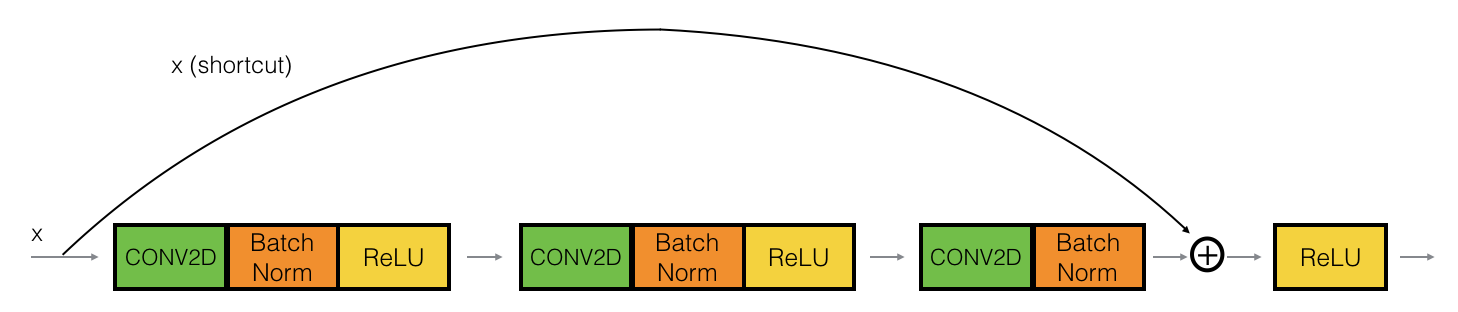

**Here the activation from the zeroth layer is added to the output of 3rd layer, before applying the activation.
The function created takes input from previous layer 'X';<br>
F1, F2, F3 are the number of filters for the 1st, 2nd and 3rd convolutional layer.<br>
f is the filter size of the middle layer (i.e 2nd layer)**<br>

**The output size of the identity block is same as the input size. Because in first and third layers<br>
filter size and strides used are (1,1) and 'valid' padding is applied. Therefore, as per formula<br> 
output_size = ((input_size - 1)/1 - 1) = input_size.<br> 
And 'same' padding is applied in the 2nd layer. Therefore the size remains same.**<br>

In [ ]:
def identity_block(X,F1,F2,F3,f):
    X_shortcut = X
    
    X = layers.Conv2D(filters=F1,kernel_size=(1,1),strides=(1,1),padding="valid")(X)
    X = layers.BatchNormalization(axis=-1)(X)
    X = layers.Activation('relu')(X)
    
    X =X = layers.Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding="same")(X)
    X = layers.BatchNormalization(axis=-1)(X)
    X = layers.Activation('relu')(X) 
    
    X = layers.Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding="valid")(X)
    X = layers.BatchNormalization(axis=-1)(X)
    
    X = layers.Add()([X,X_shortcut])
    X = layers.Activation('relu')(X)
    return X

**2.) Convolutional Block<br>
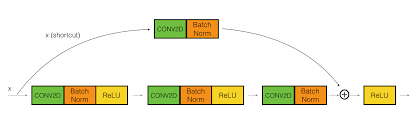

Here the activation from the zeroth layer is first passed through convolutional and batch normalization layer, then added to the output of 3rd layer (before applying the activation).
The function created takes input from previous layer 'X';<br>
F1, F2, F3 are the number of filters for the 1st, 2nd and 3rd convolutional layer.<br>
f is the filter size of the middle layer (i.e 2nd layer)<br>
s is the strides for the convolutional layer used in the shortcut route<br>
The output size of the identity block depends on the stride s of the outer convolutional layer. Because in the outer convolutional layer, filter size and strides used are (1,1) and (s,s) respectively and 'valid' padding is applied. Therefore, as per formula<br> 
output_size = ((input_size - 1)/s - 1)**<br> 

**Strides 's' is applied for 1st layer in order to match the output of the outer layer.**

In [ ]:
def conv_block(X,F1,F2,F3,f,s):
    X_shortcut = X
    
    X = layers.Conv2D(filters=F1,kernel_size=(1,1),strides=(s,s),padding="valid")(X)
    X = layers.BatchNormalization(axis=-1)(X)
    X = layers.Activation('relu')(X)
    
    X =X = layers.Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding="same")(X)
    X = layers.BatchNormalization(axis=-1)(X)
    X = layers.Activation('relu')(X) 
    
    X = layers.Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding="valid")(X)
    X = layers.BatchNormalization(axis=-1)(X)
    
    X_shortcut = layers.Conv2D(filters=F3,kernel_size=(1,1),strides=(s,s),padding="valid")(X_shortcut)
    X_shortcut = layers.BatchNormalization(axis=-1)(X_shortcut) 
    
    X = layers.Add()([X,X_shortcut])
    X = layers.Activation('relu')(X)
    return X

In [ ]:
from tensorflow.keras import Model

**Following architecture is for the ResNet 50:**
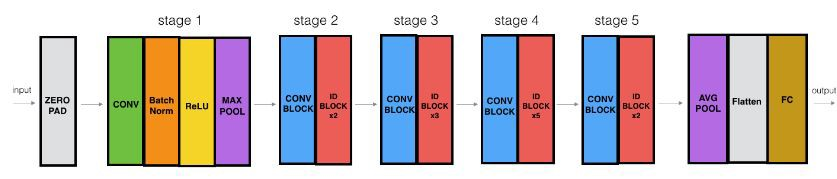
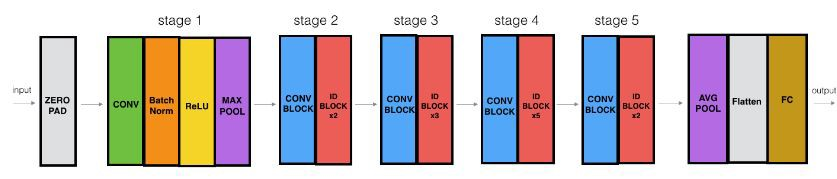

In [ ]:
def ResNet50(input_shape=(96,96,1),classes = 2):
    
    x_input = layers.Input(input_shape)
    
    x = layers.ZeroPadding2D((2,2))(x_input)
    
    x = layers.Conv2D(filters=4,kernel_size=(3,3),strides=(1,1),padding='valid')(x)
    x = layers.BatchNormalization(axis=-1)(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
    
    x = conv_block(x,4,4,16,f=3,s=1)
    x = identity_block(x,4,4,16,f=3)
    x = identity_block(x,4,4,16,f=3)
    
    x = conv_block(x,8,8,32,f=3,s=1)
    x = identity_block(x,8,8,32,f=3)
    x = identity_block(x,8,8,32,f=3)
    x = identity_block(x,8,8,32,f=3)

    x = conv_block(x,16,16,64,f=3,s=2)
    x = identity_block(x,16,16,64,f=3)
    x = identity_block(x,16,16,64,f=3)
    x = identity_block(x,16,16,64,f=3)
    x = identity_block(x,16,16,64,f=3)
    x = identity_block(x,16,16,64,f=3)
    
    x = conv_block(x,32,32,128,f=3,s=2)
    x = identity_block(x,32,32,128,f=3)
    x = identity_block(x,32,32,128,f=3)
    
    x = layers.AveragePooling2D(pool_size=(2,2),strides=(2,2))(x)
    x = layers.Flatten()(x)
    
    model = Model(inputs = x_input,outputs=x)
    
    return model

In [ ]:
main_model = ResNet50()

**The nose_tip_model is construted, after adding 1 dropout layer and 2 dense layers (with 1000 and 2 hidden units & relu activations for both hidden layers)**

In [ ]:
nose_tip_model = Sequential([
    layers.Input((96,96,1)),
    main_model,
    layers.Dropout(0.2),
    layers.Dense(1000,activation='relu'),
    layers.Dense(2,activation='relu')
])
nose_tip_model.summary()

In [ ]:
nose_tip_model.compile(optimizer='Adam',loss="mse",metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
x = x/x.max()
from sklearn.model_selection import train_test_split as tts
x_train,x_test,y_train,y_test = tts(x,y,test_size=0.05,random_state=110)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

In [ ]:
history = nose_tip_model.fit(x_train,y_train,batch_size=32,epochs=50,validation_data=(x_test,y_test))

In [ ]:
nose_tip_model.save('nose_tip_model.h5')

**The below is the implementation of the fine tuning idea discussed above, it is showed for 'bottom center of mouth' facial point. It is applied on all facial point, and a model is saved for all of them. 
Same steps are repeated for different facial point detection.**

In [ ]:
left_m_center_model = tf.keras.models.load_model('/kaggle/input/nose-tip-model/nose_tip_model.h5')
left_m_center_model.summary()

In [ ]:
left_m_center_model.layers[0].trainable = False

In [ ]:
x_mouth_center_bottom = x[df.iloc[:,29].notna()]
x_mouth_center_bottom.shape

In [ ]:
y = np.array(df.iloc[:,28:30][df.iloc[:,29].notna()])
print(y.shape)

In [ ]:
from sklearn.model_selection import train_test_split as tts
x_mouth_center_bottom = x_mouth_center_bottom/x_mouth_center_bottom.max()
x_train,x_test,y_train,y_test = tts(x_mouth_center_bottom,y,test_size=0.07,random_state=110)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

In [ ]:
left_m_center_model.compile(optimizer='Adam',loss="mse",metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
history = left_m_center_model.fit(x_train,y_train,batch_size=32,epochs=50,validation_data=(x_test,y_test))

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epochs')

In [ ]:
left_m_center_model.save('left_m_center_model.h5')

**Now all the models, saved are loaded in the notebook. The saved models are availaible as datasets. You can download and check for yourself if it works.**

In [ ]:
nose_tip_model = tf.keras.models.load_model('/kaggle/input/nose-tip-model/nose_tip_model.h5')
left_eye_icorner = tf.keras.models.load_model('/kaggle/input/all-points/left_eye_icorner.h5')
left_eye_ocorner = tf.keras.models.load_model('/kaggle/input/all-points/left_eye_ocorner.h5')
left_eyebrow_iend = tf.keras.models.load_model('/kaggle/input/all-points/left_eyebrow_iend.h5')
mouth_right_corner = tf.keras.models.load_model('/kaggle/input/all-points/x_rmouth_corner.h5')
left_eye_center = tf.keras.models.load_model('/kaggle/input/all-points/left_eye_center.h5')
right_eye_center = tf.keras.models.load_model('/kaggle/input/all-points/right_eye_center.h5')
left_eyebrow_oend = tf.keras.models.load_model('/kaggle/input/all-points/left_eyebrow_oend.h5')
mouth_bottom_center_lip = tf.keras.models.load_model('/kaggle/input/all-points/mouth_bottom_center_lip.h5')
right_eye_icorner = tf.keras.models.load_model('/kaggle/input/all-points/right_eye_icorner.h5')
right_eyebrow_iend = tf.keras.models.load_model('/kaggle/input/all-points/right_eyebrow_iend.h5')
mouth_center_top_lip = tf.keras.models.load_model('/kaggle/input/all-points-2/mouth_center_top_lip.h5')
mouth_left_corner = tf.keras.models.load_model('/kaggle/input/all-points-2/x_lmouth_corner.h5')
right_eye_ocorner = tf.keras.models.load_model('/kaggle/input/all-points-2/right_eye_ocorner.h5')
right_eyebrow_oend = tf.keras.models.load_model('/kaggle/input/all-points-2/right_eyebrow_oend.h5')


In [ ]:
df_sample = pd.read_csv('/kaggle/input/facial-keypoints-detection/SampleSubmission.csv')
df_sample.head()

In [ ]:
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "/kaggle/input/facial-keypoints-detection/test.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

In [ ]:
df_test = pd.read_csv('./test.csv')
df_test.info()

**Same preprocessing steps are applied to the test data.**

In [ ]:
x_test_final = np.zeros((df_test.shape[0],96,96,1))
for i in range(df_test.shape[0]):
    arr = np.array(df_test.iloc[i,-1].split()).reshape(96,96,1)
    x_test_final[i] = arr.astype(float)
print(x_test_final.shape)


In [ ]:
x_test_final = x_test_final/x_test_final.max()

In [ ]:
print(x_test_final.shape)

**A solution array (solln_arr) is created for storing the predicted results. The test data is given to the different models, one by one and the predicted results are stoored in the solln_arr.**

In [ ]:
solln_arr = np.zeros((1783,30))
model_lst = [nose_tip_model,left_eye_icorner,left_eye_ocorner,left_eyebrow_iend,mouth_right_corner,left_eye_center,right_eye_center,left_eyebrow_oend,mouth_bottom_center_lip,right_eye_icorner,right_eyebrow_iend,mouth_center_top_lip,mouth_left_corner,right_eye_ocorner,right_eyebrow_oend]
for i in range(len(model_lst)):
    solln_arr[:,2*i:2*i+2] = model_lst[i].predict(x_test_final)

In [ ]:
print(solln_arr)

**Let us have a look at our genrated results. The same technique is used for visualization as described above for training data.**

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.imshow(x_test_final[i])
    for j in range(len(model_lst)):
        plt.scatter(solln_arr[i,2*j],solln_arr[i,2*j+1],color='red')
    

**Considerable accuracy is obtained using the *fine_tuning* technique. One of the main hyperparameter is left unexplored i.e., the number of layers to be freezed. Currently only *dense* layers are used as trainable layers for fine tuning. Number of layers can be varied.**

Let me know your ideas regarding the above implementation. Let me know, if you use the availaible models and face any issues.